In [ ]:
# 不同时间步T，网络结构一致性对比（计算）
# 不同时间步T的网络比较
import pandas as pd
import numpy as np
import os
from itertools import combinations

# 筛选权重前5%边并归一化
def preprocess_edges(file_path, top_percent=0.05):
    edges = pd.read_csv(file_path)
    assert 'weight' in edges.columns, f"{file_path} 缺少 'weight' 列"

    # 保留前top_percent的边
    threshold = edges['weight'].quantile(1 - top_percent)
    filtered_edges = edges[edges['weight'] >= threshold].copy()

    # 权重归一化（按总和）
    total_weight = filtered_edges['weight'].sum()
    filtered_edges['weight_norm'] = filtered_edges['weight'] / total_weight
    filtered_edges['weight_norm'] = filtered_edges['weight_norm'].round(6)

    # 构建字典
    weight_dict = {
        (int(row['Source']), int(row['Target'])): row['weight_norm']
        for _, row in filtered_edges.iterrows()
    }
    return weight_dict, len(filtered_edges)

# 拓扑距离计算
def calculate_topology_distance(dict1, dict2, n_nodes=200):
    all_possible_edges = [(i, j) for i in range(n_nodes) for j in range(n_nodes) if i != j]
    topology_distance = sum((edge in dict1) != (edge in dict2) for edge in all_possible_edges)
    avg_edges = (len(dict1) + len(dict2)) / 2
    return topology_distance / avg_edges if avg_edges > 0 else 0.0

# 权重距离（0-1法）
def calculate_binary_weight_distance(reference_edges, compare_edges, threshold=0.1):
    error_count = 0
    for edge, w1 in reference_edges.items():
        w2 = compare_edges.get(edge, 0.0)
        relative_error = abs(w1 - w2) / w1 if w1 > 0 else 1.0
        if relative_error >= threshold:
            error_count += 1
    return error_count / len(reference_edges) if reference_edges else 0.0

# 主执行函数
def run_batch_comparison(edge_folder, t_values, output_csv_path):
    results = []
    weight_dicts = {}

    # 预处理所有文件
    for T in t_values:
        file_path = os.path.join(edge_folder, f"T{T}(1)\edges.csv")
        weight_dict, num_edges = preprocess_edges(file_path)
        weight_dicts[T] = weight_dict
        print(f"T={T} 完成预处理，筛选边数: {num_edges}")

    # 两两比较
    for T1, T2 in combinations(t_values, 2):
        dict1 = weight_dicts[T1]
        dict2 = weight_dicts[T2]

        topo_dist = calculate_topology_distance(dict1, dict2)
        dist1 = calculate_binary_weight_distance(dict1, dict2)
        dist2 = calculate_binary_weight_distance(dict2, dict1)
        weight_dist = (dist1 + dist2) / 2

        results.append({
            'T1': T1,
            'T2': T2,
            'topo_distance': round(topo_dist, 3),
            'weight_distance': round(weight_dist, 3)
        })

    # 保存结果
    df_result = pd.DataFrame(results)
    df_result.to_csv(output_csv_path, index=False)
    print(f"比较结果已保存至 {output_csv_path}")

# 示例调用
if __name__ == "__main__":
    #t_values = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    t_values = [500, 600, 700, 800, 900, 1000]
    #edge_folder = r"c:\Users\Administrator\Desktop\test_files"
    edge_folder = r"c:\Users\Administrator\Desktop\network_generate\network_generate"
    output_csv_path = r"c:\Users\Administrator\Desktop\test_files\network_comparison_result.csv"
    run_batch_comparison(edge_folder, t_values, output_csv_path)


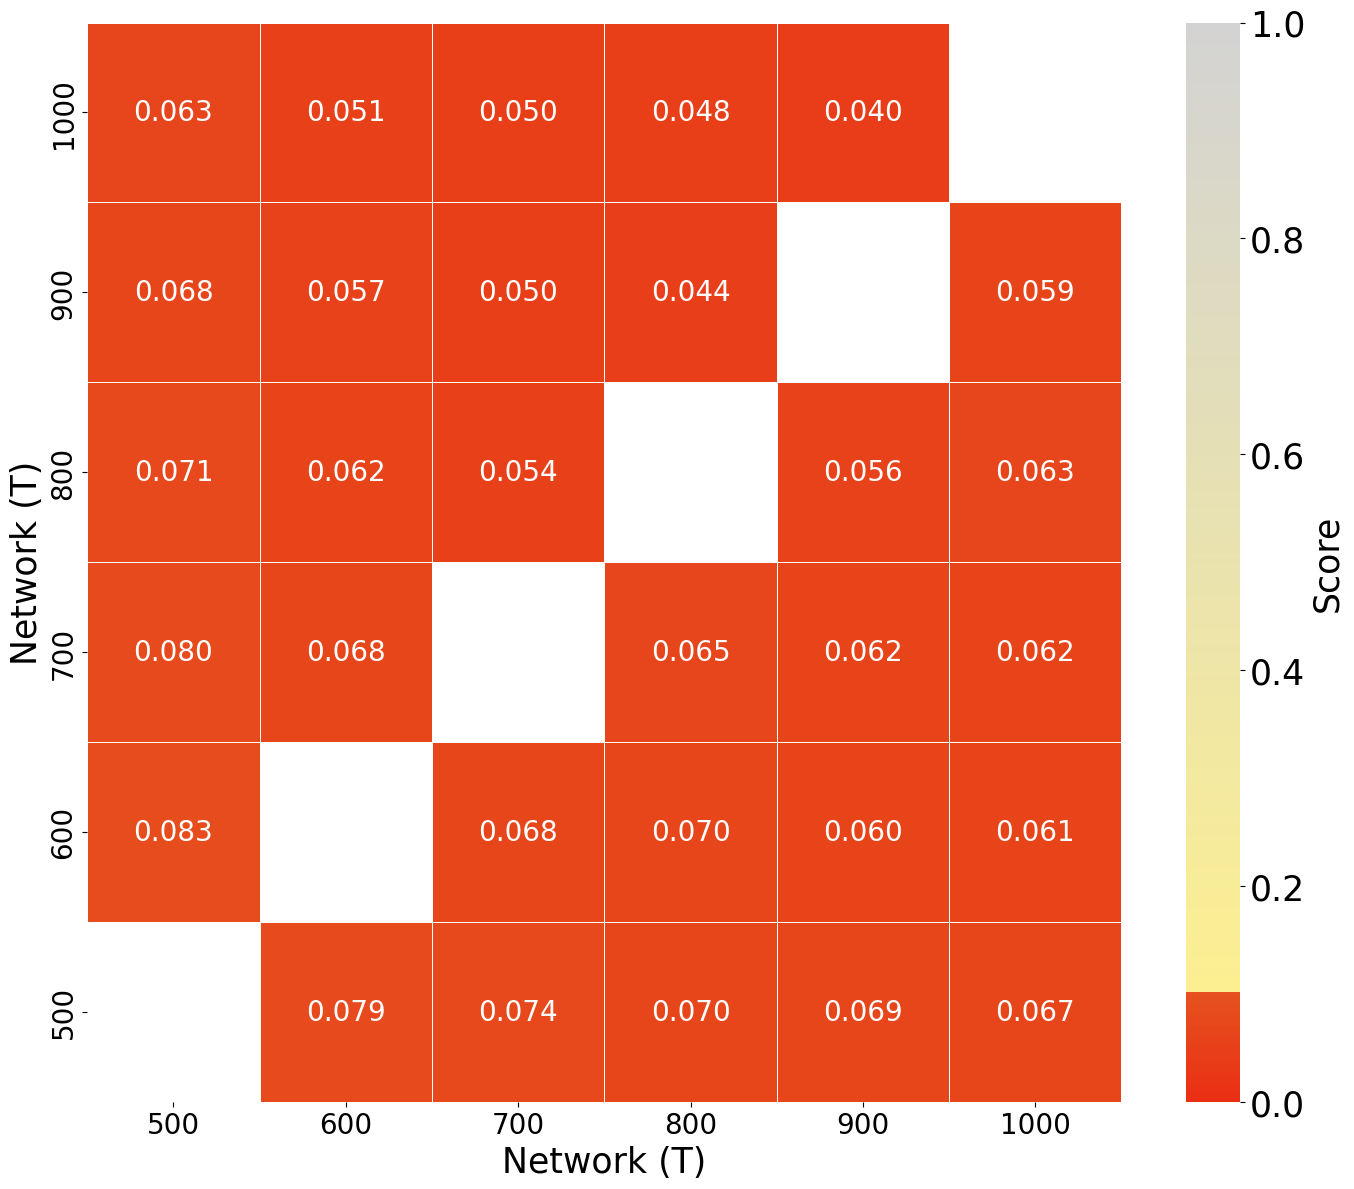

In [1]:
# 不同时间步T，网络结构一致性对比（作图）
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 1. 读取数据
df = pd.read_csv(r"c:\Users\Administrator\Desktop\test_files\network_comparison_result.csv")

# 2. 网络编号排序
networks = sorted(list(set(df['T1'].unique()) | set(df['T2'].unique())))
n = len(networks)

# 3. 初始化距离矩阵
topo_matrix = np.full((n, n), np.nan)
weight_matrix = np.full((n, n), np.nan)

for _, row in df.iterrows():
    i = networks.index(row['T1'])
    j = networks.index(row['T2'])
    topo_matrix[i, j] = row['topo_distance']
    topo_matrix[j, i] = row['topo_distance']
    weight_matrix[i, j] = row['weight_distance']
    weight_matrix[j, i] = row['weight_distance']

# 4. 合并上下三角
combined_matrix = np.zeros((n, n))
combined_matrix[np.triu_indices(n)] = topo_matrix[np.triu_indices(n)]
combined_matrix[np.tril_indices(n, -1)] = weight_matrix[np.tril_indices(n, -1)]

# 5. 自定义颜色映射
colors = [(0, '#EA2F14'), (0.1, '#E6521F'), (0.1, '#FCEF91'), (1, 'lightgrey')]
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# 6. 绘图
plt.figure(figsize=(14, 12))
ax = sns.heatmap(combined_matrix,
                 annot=True,
                 fmt=".3f",
                 cmap=cmap,
                 vmin=0,
                 vmax=1,
                 linewidths=0.5,
                 xticklabels=networks,
                 yticklabels=networks,
                 annot_kws={"size": 20},
                 cbar_kws={'label': 'Score'})

# 7. 字体设置
ax.set_xlabel('Network (T)', fontsize=25)
ax.set_ylabel('Network (T)', fontsize=25)
ax.tick_params(axis='both', labelsize=20)

# 色条字体加大加粗
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Score', fontsize=25)

# 8. 坐标方向
ax.invert_yaxis()

# 9. 图例说明文字
'''ax.text(0.5, -0.15,
        "Upper left: Topological Distance\nLower right: Weighted Distance\nRed boxes: Values < 0.1",
        transform=ax.transAxes,
        ha='center',
        va='top',
        fontsize=20,
        bbox=dict(facecolor='white', alpha=0.8))
'''
# 10. 保存图像（高清PDF）
plt.tight_layout()
plt.savefig(r'c:\Users\Administrator\Desktop\network_generate1\plots\Comparison_network.pdf', dpi=300, bbox_inches='tight')
plt.show()
